In [1]:
import mysql.connector
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from efficient_apriori import apriori
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS 

# Group 8: Instacart Market Basket Analysis

In [33]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [41]:
cnx = mysql.connector.connect(user='root', password='root',
                              host='localhost',
                              database='project_schema')

if cnx.is_connected():
    print("Connected")

Connected


## Wordplot of Products by Orders

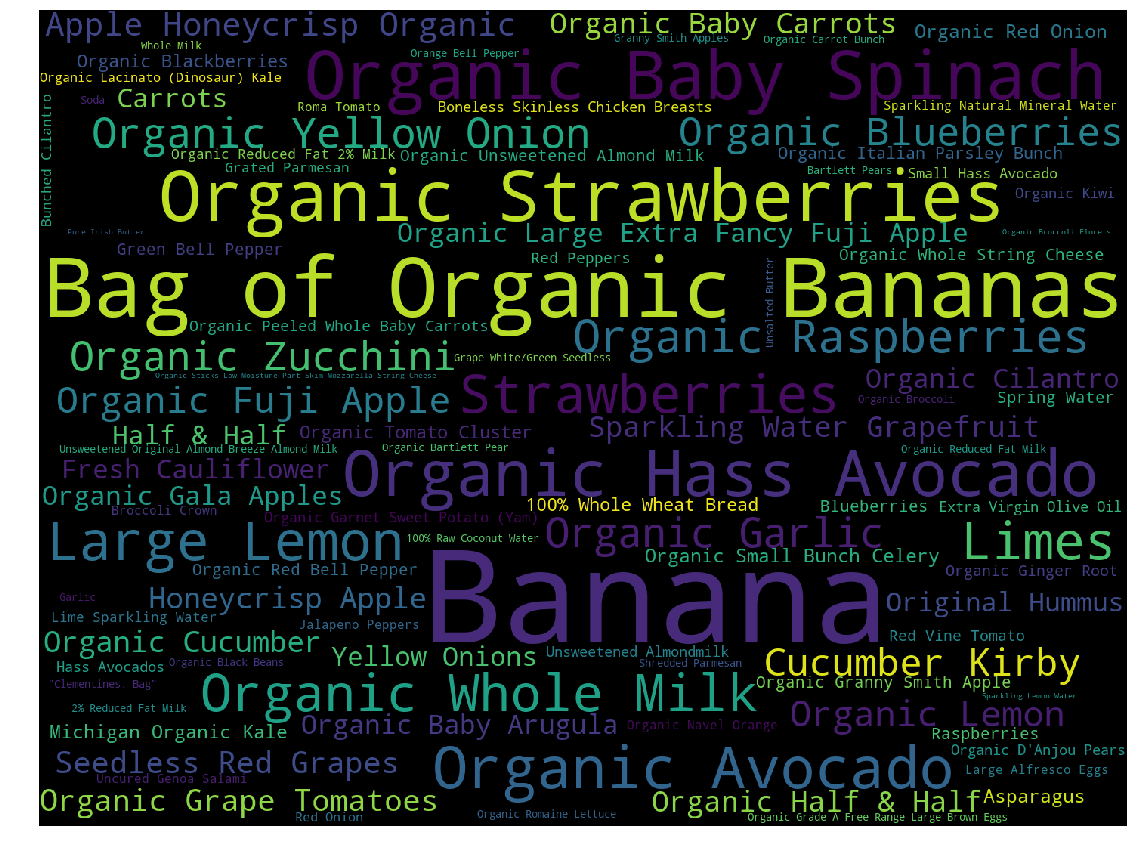

In [38]:
dfMostOrderedProductsDf=pd.DataFrame(pd.read_sql('''select  p.product_name, a.cnt
from 
(select  o.product_id , count(o.product_id) cnt
from  order_products__prior o
 group by o.product_id
order by cnt desc 
LIMIT  100) a
inner join products p 
on p.product_id = a.product_id
''',con = cnx))
wordsAndCount = dict(zip(dfMostOrderedProductsDf['product_name'], dfMostOrderedProductsDf['cnt']))
cloud = WordCloud(width=1440, height=1080).generate_from_frequencies(wordsAndCount)
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')
plt.show()

## Highest Ordered Products

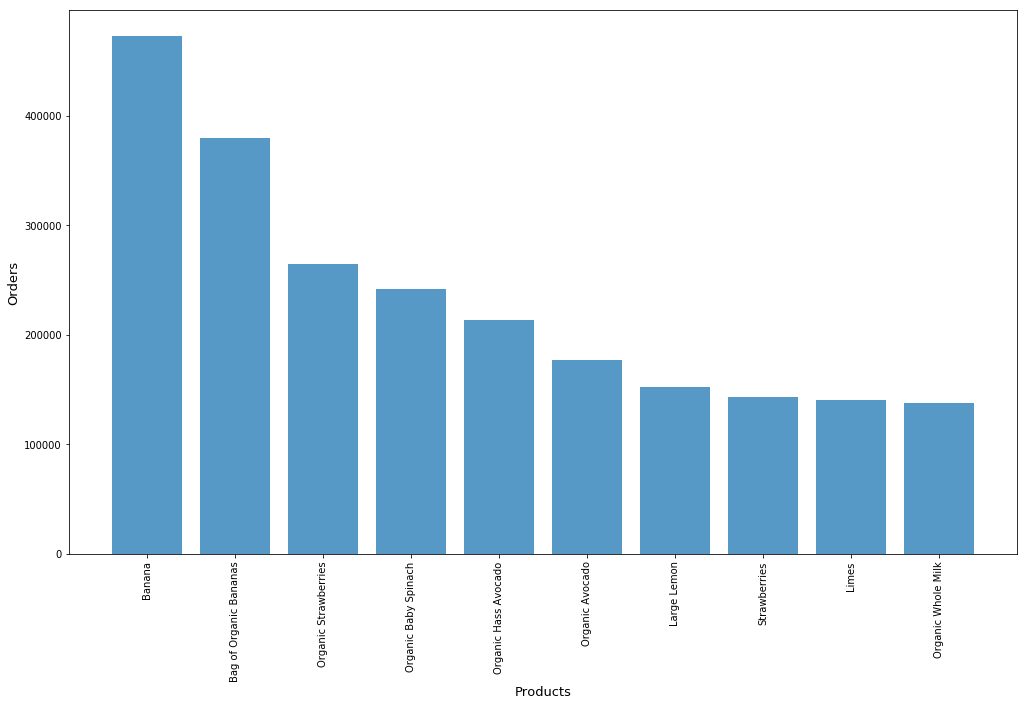

In [42]:
### Most ordered item
query = """select a.product_id , p.product_name, a.cnt
from 
(select  o.product_id , count(o.product_id) cnt
from  order_products__prior o
 group by o.product_id
order by cnt desc 
LIMIT  10) a
inner join products p 
on p.product_id = a.product_id"""
     
cursor = cnx.cursor()

cursor.execute(query)
l1 = []
l2 = []
for (product_id, product_name, cnt) in cursor:
    l1.append(cnt)
    l2.append(product_name)

plt.bar(np.arange(len(l1)), l1, align='center', alpha=0.75)
plt.rcParams['figure.figsize'] = [10, 10]
plt.xticks(rotation='vertical')
plt.xticks(np.arange(len(l1)), l2)
plt.ylabel('Orders', fontsize=13)
plt.xlabel('Products', fontsize=13)
plt.show()

## Products by No. of users

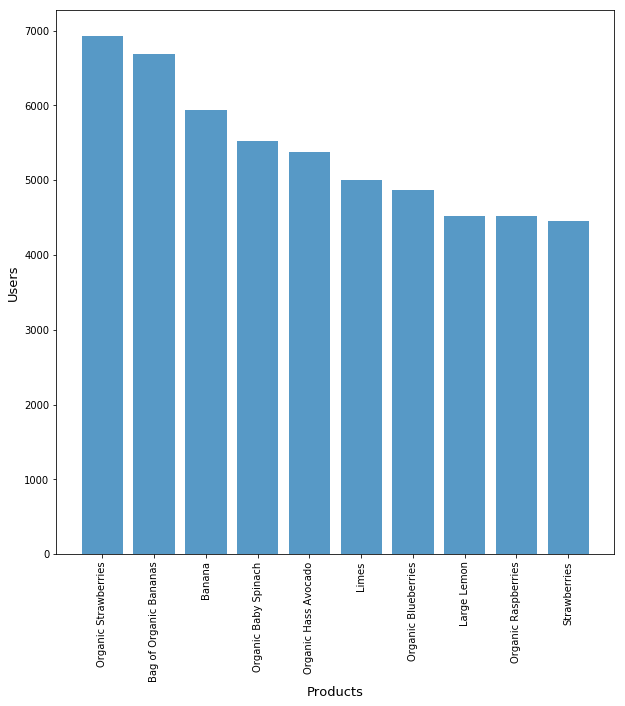

In [45]:
productsOrderedByUsersDf = pd.read_sql('''select p.product_name, src1.product_id, src1.users
from products p inner join 
(select opm.product_id,count(distinct o.user_id) users
from project_schema.order_products__prior3 opm inner join project_schema.orders2 o on opm.order_id = o.order_id
group by product_id
order by users desc
LIMIT 10) src1 on p.product_id = src1.product_id''', con=cnx)
    
plt.bar(np.arange(len(productsOrderedByUsersDf['users'])), productsOrderedByUsersDf['users'], align='center', alpha=0.75)
plt.xticks(rotation='vertical')
plt.rcParams['figure.figsize'] = [10, 10]
plt.xticks(np.arange(len(productsOrderedByUsersDf['users'])), productsOrderedByUsersDf['product_name'])
plt.ylabel('Users', fontsize=13)
plt.xlabel('Products', fontsize=13)
#plt.title('Most users ordered product')
plt.show()

## Products by Department

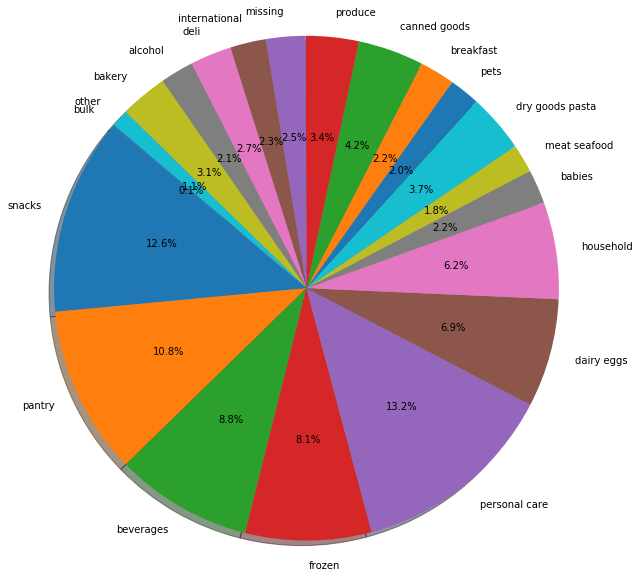

In [48]:
productsByDeptDf = pd.read_sql('''select d.department_id, d.department,count(*) products
from products p inner join departments d on p.department_id = d.department_id
group by d.department_id
''', con=cnx)

labels = productsByDeptDf['department'].values
sizes = productsByDeptDf['products'].values

 
# Plot
plt.pie(sizes,  labels=labels, 
        autopct='%1.1f%%', shadow=True, startangle=140)
#plt.title('Products By department', y=1.08, fontsize=20) 
plt.axis('equal')
plt.show()

## Orders By Department

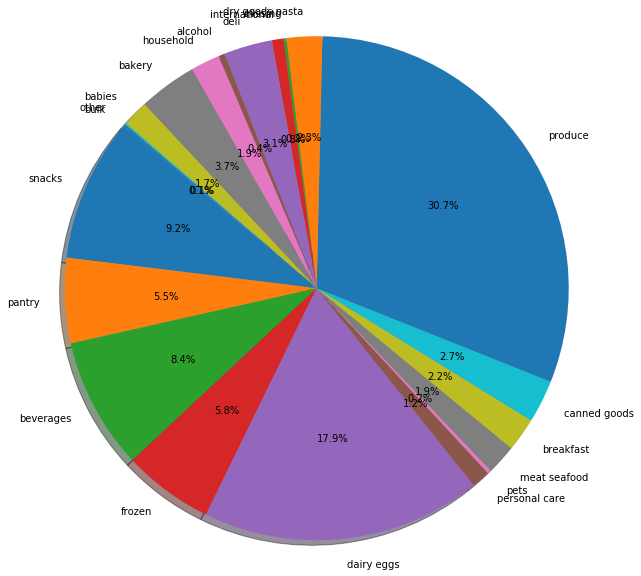

In [46]:
ordersByDeptDf = pd.read_sql('''select d.department_id, d.department,count(*) orders
from project_schema.order_products__prior3 opm 
inner join products p on p.product_id = opm.product_id inner join departments d on p.department_id = d.department_id
group by d.department_id
''', con=cnx)

labels = ordersByDeptDf['department'].values
sizes = ordersByDeptDf['orders'].values

plt.rcParams['figure.figsize'] = [10, 10]
# Plot
plt.pie(sizes,  labels=labels, 
        autopct='%1.1f%%', shadow=True, startangle=140)

#plt.title('Orders By department', y=1.08, fontsize=20)

plt.axis('equal')
plt.show()


## Tree plot of Orders by Departments

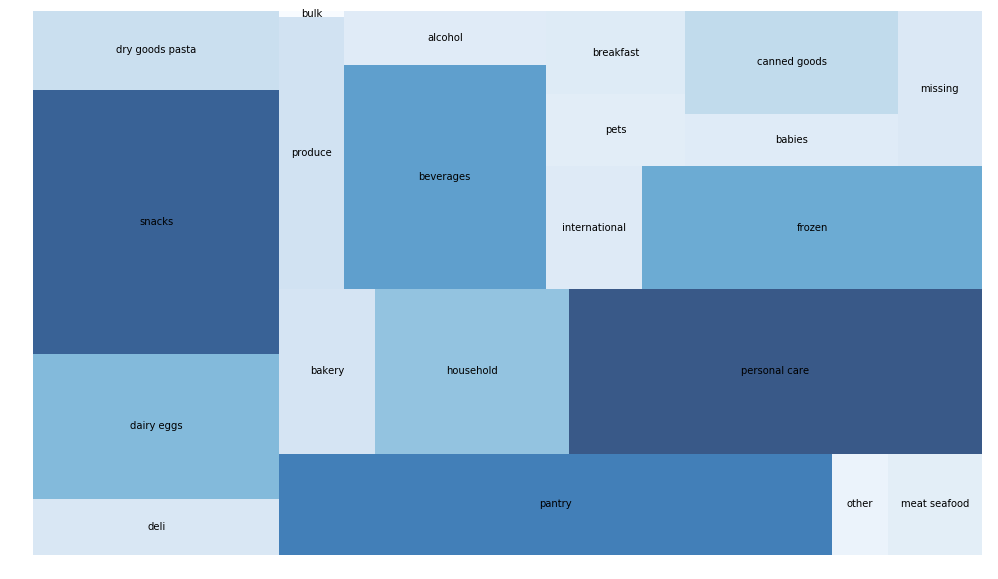

In [37]:
#### Plot 2 ####
# Distribution of products across Aisle and department

products_df = pd.read_sql('''select p.aisle as Aisle,p.department as Department,count(p.product_name) as Products from (
select temp.*,d.department from (select p.*,a.aisle from products p left join aisles a on p.aisle_id=a.aisle_id) as temp left join
departments as d on temp.department_id=d.department_id) as p
group by p.aisle,p.department;''', con=cnx)
  
aisle_df = pd.read_sql('''select p.aisle as Aisle,count(p.product_name) as Products from (
select temp.*,d.department from (select p.*,a.aisle from products p left join aisles a on p.aisle_id=a.aisle_id) as temp left join
departments as d on temp.department_id=d.department_id) as p
group by p.aisle;''', con=cnx)
  
department_df = pd.read_sql('''select p.department as Department,count(p.product_name) as Products from (
select temp.*,d.department from (select p.*,a.aisle from products p left join aisles a on p.aisle_id=a.aisle_id) as temp left join
departments as d on temp.department_id=d.department_id) as p
group by p.department;''', con=cnx)
    
import squarify
plt.rcParams['figure.figsize'] = [17, 10]

cmap = matplotlib.cm.Blues
mini=min(department_df['Products'])
maxi=max(department_df['Products'])
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in department_df['Products']]
 
# Change color
squarify.plot(sizes=department_df['Products'], label=department_df["Department"], alpha=.8, color=colors )
plt.axis('off')
plt.show()

## Total Orders vs Total Users

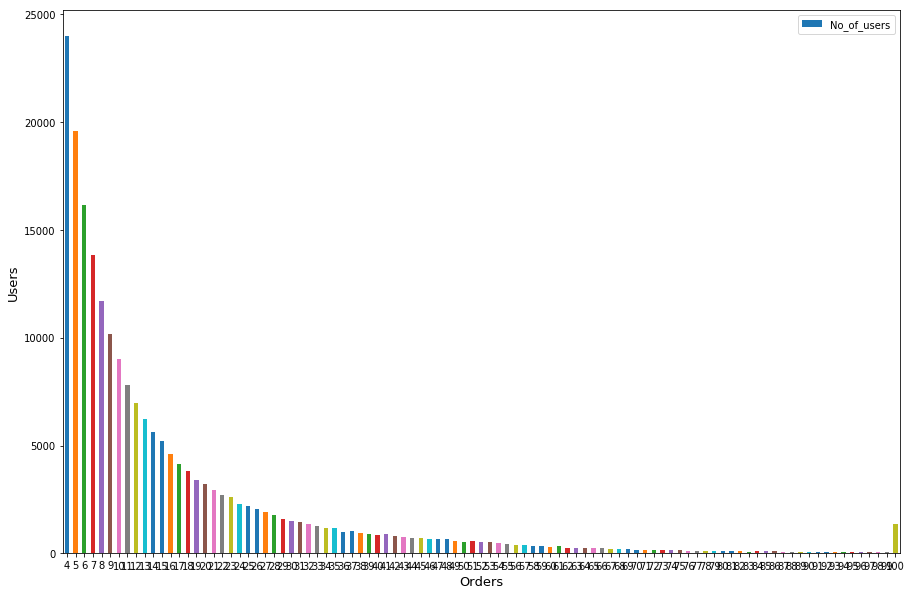

In [49]:
### Plot 1 ####
# No of Users by their total Orders
user_order_df = pd.read_sql('''select a.noOfOrders as Total_no_of_orders, 
  count(a.user_id) as No_of_users from (select user_id, max(order_number) noOfOrders
from orders group by user_id order by noOfOrders) as a
group by a.noOfOrders ;''', con=cnx)
plt.rcParams['figure.figsize'] = [15, 10]
plot1=user_order_df.plot.bar(x='Total_no_of_orders', y='No_of_users', rot=1)
plt.ylabel('Users', fontsize=13)
plt.xlabel('Orders', fontsize=13)
# plt.title('Total Orders vs Total Users', y=1, fontsize=20)
plt.show()

Text(0.5,0,'Day of the Week')

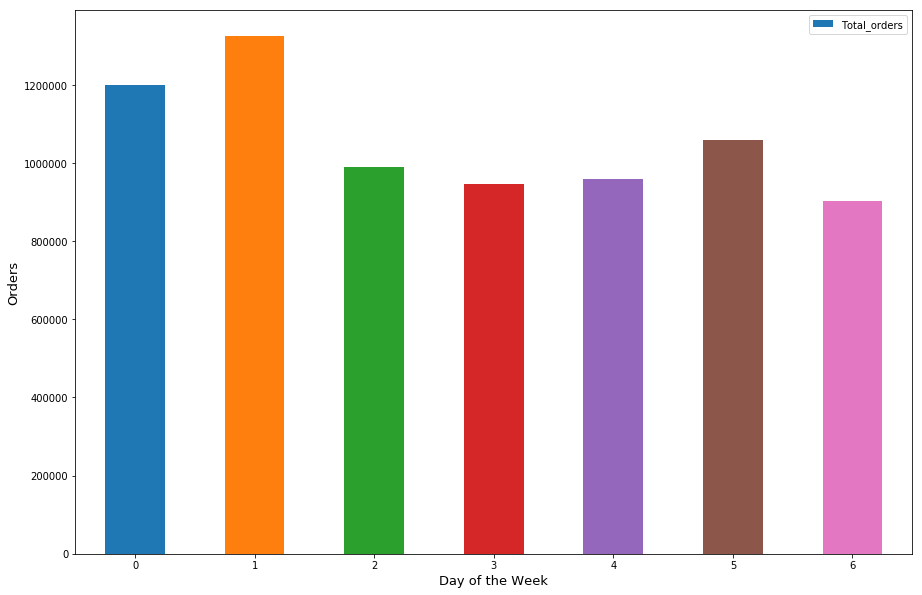

In [50]:
##### Plot 3 ####
# Frequency of orders by day of the week

dow_df = pd.read_sql('''select order_dow as day_of_the_week ,count(*) Total_orders, sum(reordered) Re_ordered_no, (sum(reordered)/count(*))*100 as Reorder_percent
from
(select opm.product_id, o.user_id, o.order_number as order_number ,opm.reordered, opm.order_id , o.order_hour_of_day, 
 o.days_since_prior_order, o.order_dow
from project_schema.order_products__prior3 opm inner join project_schema.orders2 o on opm.order_id = o.order_id
#where user_id = 182401 ) src1
) src1
group by order_dow
order by order_dow;''', con=cnx)

hod_df = pd.read_sql('''select  order_hour_of_day, count(*) Total_orders
from
(select opm.product_id, o.user_id, o.order_number as order_number ,opm.reordered, opm.order_id , o.order_hour_of_day, 
 o.days_since_prior_order, o.order_dow
from project_schema.order_products__prior3 opm inner join project_schema.orders2 o on opm.order_id = o.order_id
) src1
group by order_hour_of_day
order by order_hour_of_day;''', con=cnx)

plot3_1=dow_df.plot.bar(x='day_of_the_week', y='Total_orders', rot=1)
plt.ylabel('Orders', fontsize=13)
plt.xlabel('Day of the Week', fontsize=13)


## Orders by Day of the Week

Text(0.5,0,'Day of the Week')

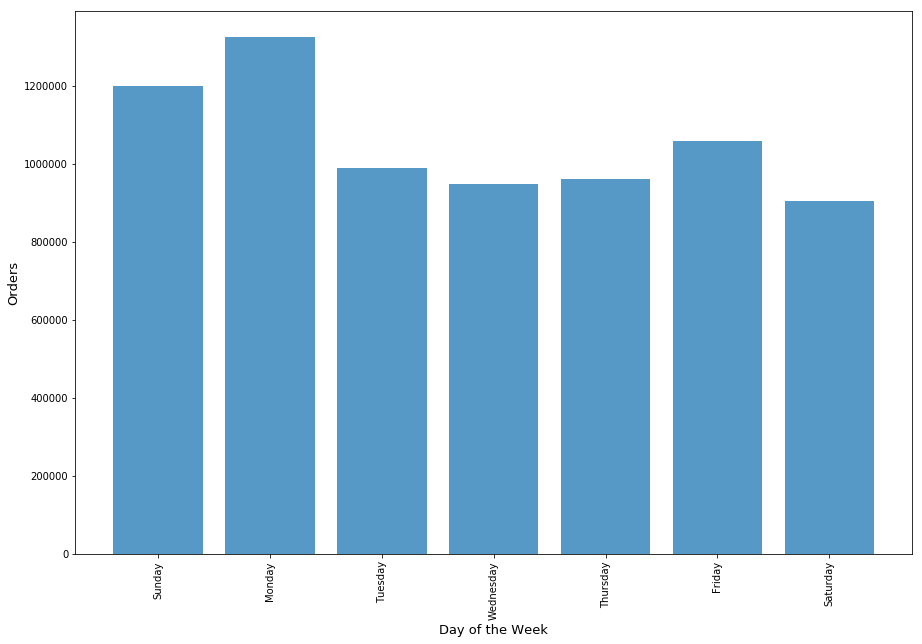

In [54]:
plt.show()
plt.bar(np.arange(len(dow_df['Total_orders'])), dow_df['Total_orders'], align='center', alpha=0.75)
plt.xticks(rotation='vertical')
plt.xticks(np.arange(len(dow_df['Total_orders'])), ['Sunday', 'Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday'])
#plt.title('Orders by Day of the Week')
#plt.show()
plt.ylabel('Orders', fontsize=13)
plt.xlabel('Day of the Week', fontsize=13)

## Orders by Hour of the day

Text(0.5,0,'Hour of the Day')

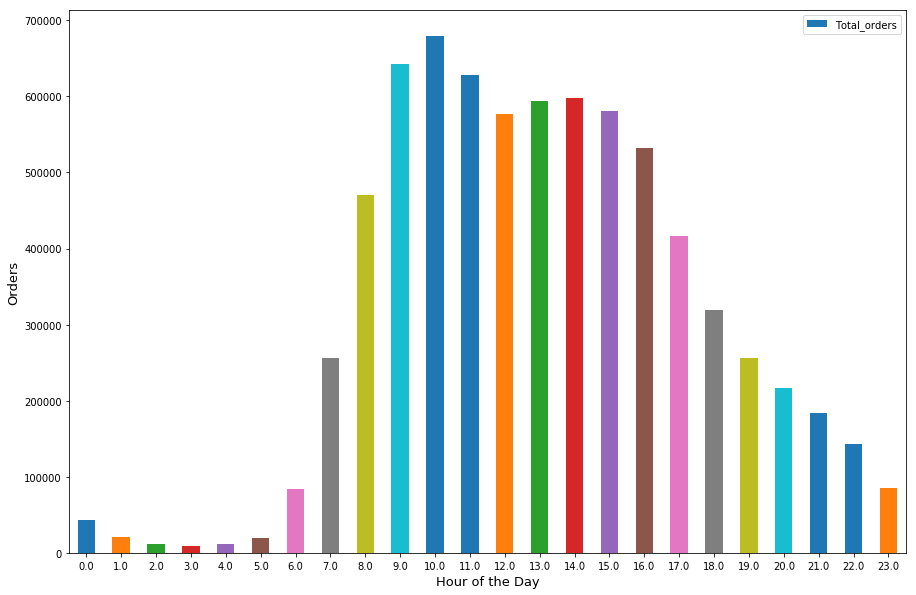

In [52]:
plot3_2=hod_df.plot.bar(x='order_hour_of_day', y='Total_orders', rot=1)
plt.ylabel('Orders', fontsize=13)
plt.xlabel('Hour of the Day', fontsize=13)

## User Order Behaviour

Text(0.5,0,'First time order')

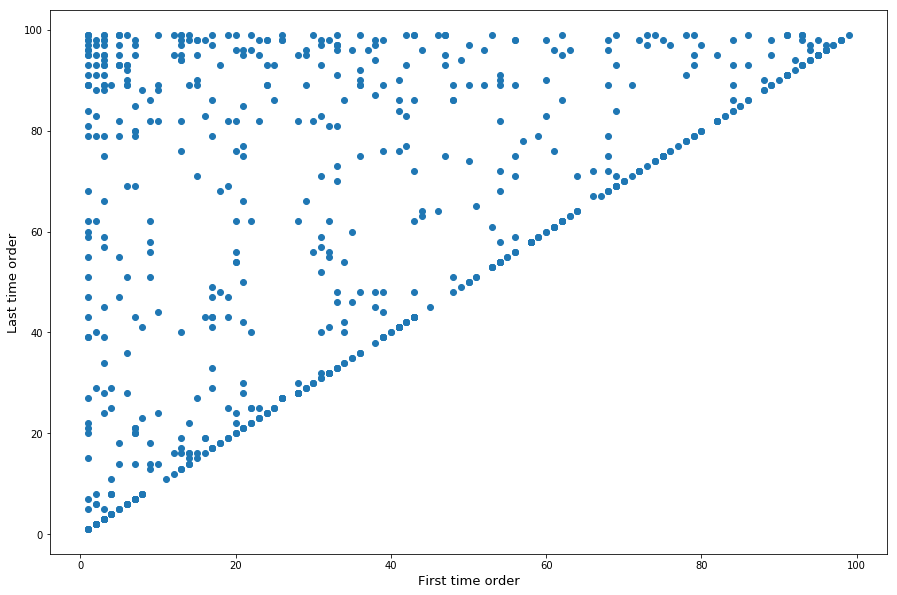

In [55]:
userReorderHistoryByItemDf = pd.read_sql("""select user_id, product_id, count(*) totalNoOfOrders, sum(reordered) noOfReordered,
        	   min(order_number) fistTimeOrder, max(order_number) lastTimeOrder
                from
                (select opm.product_id, o.user_id, o.order_number,opm.reordered, opm.order_id , o.order_hour_of_day, o.days_since_prior_order, 
                 o.order_dow
                from project_schema.order_products__prior3 opm inner join project_schema.orders2 o on opm.order_id = o.order_id
                where user_id = 182401)src1
                group by product_id, user_id;
                """,con = cnx)
                
                
plt.scatter(userReorderHistoryByItemDf['fistTimeOrder'], userReorderHistoryByItemDf['lastTimeOrder'])

plt.ylabel('Last time order', fontsize=13)
plt.xlabel('First time order', fontsize=13)

#plt.title('User Order Behaviour', y=1, fontsize=20)

## Orders vs. Re-order Probability

Text(0.5,0,'OrderSize')

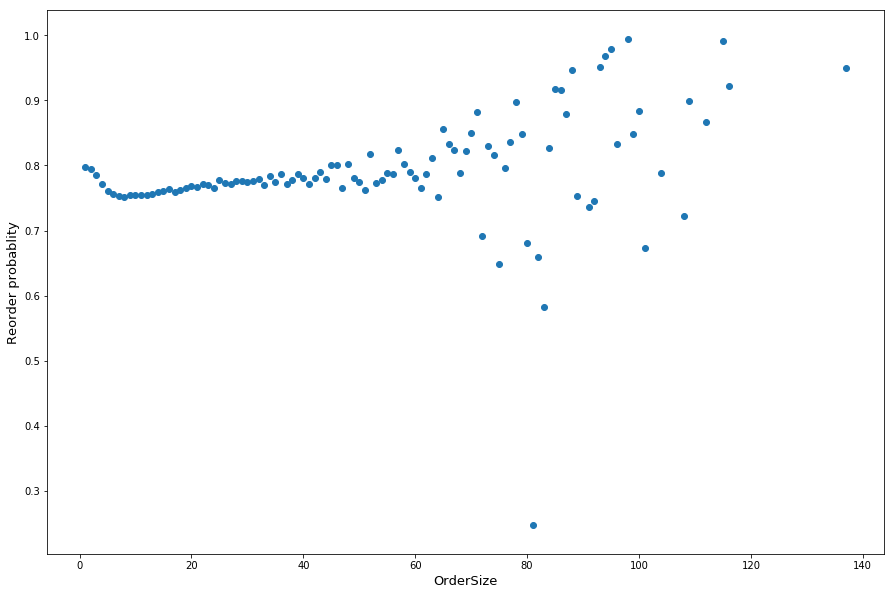

In [56]:
orderSizeVsReorderProbDf = pd.read_sql("""select src3.orderSize, avg(reOrderProb) reOrderProb
from
(select src2.order_id, orderSize, reorderCount, reorderCount/orderSize as reOrderProb
from
(select src1.order_id , count(*) orderSize , sum(src1.reordered) reorderCount
from 
(select opm.product_id, o.user_id, opm.reordered, opm.order_id 
from project_schema.order_products__prior3 opm inner join project_schema.orders2 o on opm.order_id = o.order_id
#where user_id = 182401)src1
where o.order_number <> 1)src1
group by src1.order_id) src2) src3
group by src3.orderSize""",con = cnx)

plt.scatter(orderSizeVsReorderProbDf['orderSize'], orderSizeVsReorderProbDf['reOrderProb'])

plt.ylabel('Reorder probablity', fontsize=13)
plt.xlabel('OrderSize', fontsize=13)
#plt.title('Order Size vs. Re-order Probability', y=1, fontsize=20)

## Cart position vs Reorder Probability

Text(0.5,0,'Cart position')

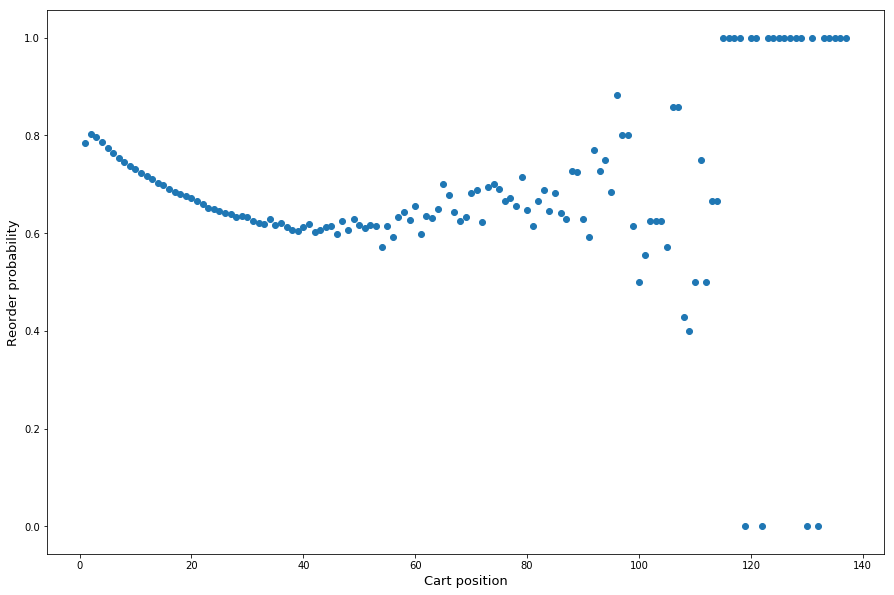

In [57]:
cartPosVsReorderProbDf = pd.read_sql("""select add_to_cart_order, count(*) totalOrders, sum(reordered) reorderCount
                                                from project_schema.order_products__prior3
                                                group by add_to_cart_order
                                                order by add_to_cart_order
                """,con = cnx)
                
                
plt.scatter(cartPosVsReorderProbDf['add_to_cart_order'], cartPosVsReorderProbDf['reorderCount']/cartPosVsReorderProbDf['totalOrders'])

plt.ylabel('Reorder probability', fontsize=13)
plt.xlabel('Cart position', fontsize=13)
#plt.title('Cart position vs Reorder Probability', y=1, fontsize=20)

## Products (vs) Average Reorder Days

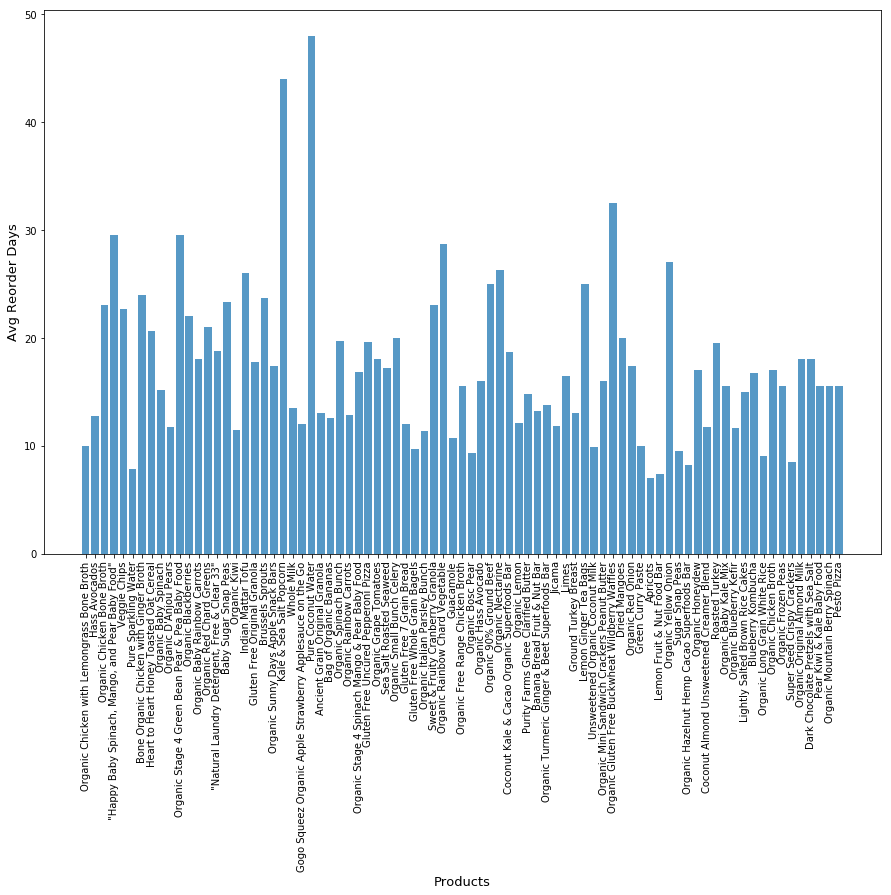

In [58]:
noOfDaysForReorderDf = pd.read_sql("""select opm.product_id, o.user_id, o.order_number as order_number ,opm.reordered, opm.order_id , o.order_hour_of_day, 
 o.days_since_prior_order, o.order_dow, p.product_name
from project_schema.order_products__prior3 opm inner join project_schema.orders2 o on opm.order_id = o.order_id
inner join products p on p.product_id = opm.product_id
where user_id = 182401
order by order_number limit 700 """,con = cnx)

ordersByUserDf = pd.read_sql("""select * from orders2 where user_id = 182401 order by order_number""",con = cnx)

uniqueProductIds = noOfDaysForReorderDf.product_id.unique()

tempDf = noOfDaysForReorderDf.loc[noOfDaysForReorderDf['product_id'] == 7781]

toBePlottedProducts = {}
for productId in uniqueProductIds:
    rowIndexes = noOfDaysForReorderDf.index[noOfDaysForReorderDf['product_id'] == productId].values
    if(len(rowIndexes) > 2):
        noOfDaysBetweenReorder = []
        for index in range(1,len(rowIndexes)):
            currOderNum = noOfDaysForReorderDf.iloc[rowIndexes[index],]['order_number']
            prevOderNum = noOfDaysForReorderDf.iloc[rowIndexes[index - 1],]['order_number']
            noOfDaysBetweenReorder.append(sum(ordersByUserDf.loc[(ordersByUserDf['order_number'] >= prevOderNum) & (ordersByUserDf['order_number'] <= currOderNum)]['days_since_prior_order']))
            
        toBePlottedProducts[noOfDaysForReorderDf.loc[noOfDaysForReorderDf['product_id'] == productId].iloc[0]['product_name']]= sum(noOfDaysBetweenReorder)/len(noOfDaysBetweenReorder)
        
plt.bar(np.arange(len(list(toBePlottedProducts.values()))), list(toBePlottedProducts.values()), align='center', alpha=0.75)
plt.xticks(rotation='vertical')
plt.xticks(np.arange(len(list(toBePlottedProducts.values()))), list(toBePlottedProducts.keys()))
#plt.title('Products (vs) Average Reorder Days', y=1, fontsize=20)
plt.ylabel('Avg Reorder Days', fontsize=13)
plt.xlabel('Products', fontsize=13)
plt.show()
        